# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

---
## Step 0: Imports and Data Load

In [1]:
import numpy as np
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pandas

/home/azabegaev/bin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
training_file = '../traffic-signs-data/train.p'
validation_file = '../traffic-signs-data/valid.p'
testing_file = '../traffic-signs-data/test.p'
names_file = './signnames.csv'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

names = pandas.io.parsers.read_csv(names_file).values[:,1]
    
X_train_pre, y_train_pre = train['features'], train['labels']
X_valid_pre, y_valid = valid['features'], valid['labels']
X_test_pre, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

### Basic Summary of the Data Set

In [3]:
# Number of training examples
n_train = X_train_pre.shape[0]

# Number of validation examples
n_validation = X_valid_pre.shape[0]

# Number of testing examples.
n_test = X_test_pre.shape[0]

# Traffic sign image shape.
image_shape = X_train_pre.shape[1:]

classes, classes_i, classes_c = np.unique(y_train_pre, return_index=True, return_counts=True)

# Number of unique classes/labels in the dataset.
n_classes = len(classes)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Dataset visualization

Class: 0. Name: "Speed limit (20km/h)". Samples: 180.


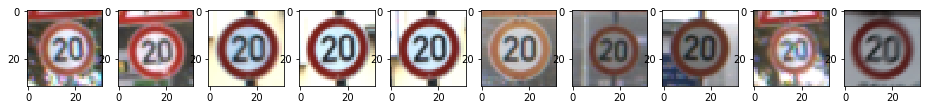

Class: 1. Name: "Speed limit (30km/h)". Samples: 1980.


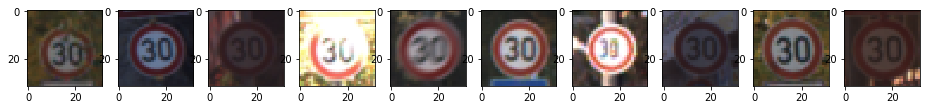

Class: 2. Name: "Speed limit (50km/h)". Samples: 2010.


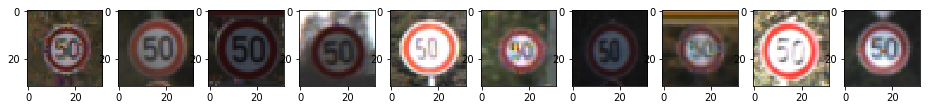

Class: 3. Name: "Speed limit (60km/h)". Samples: 1260.


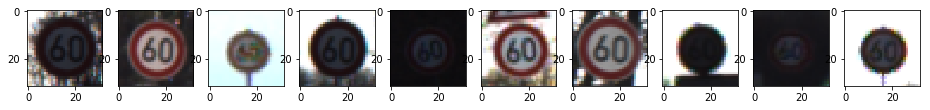

Class: 4. Name: "Speed limit (70km/h)". Samples: 1770.


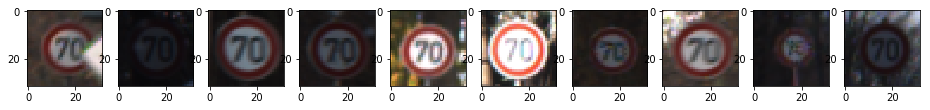

Class: 5. Name: "Speed limit (80km/h)". Samples: 1650.


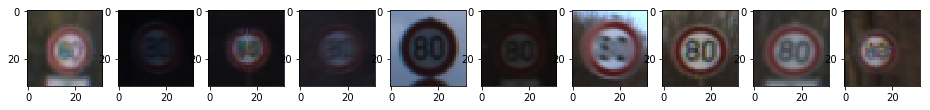

Class: 6. Name: "End of speed limit (80km/h)". Samples: 360.


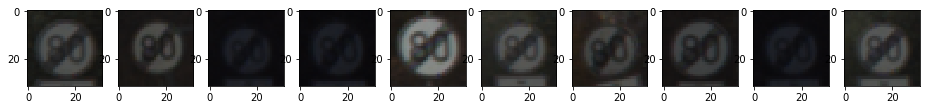

Class: 7. Name: "Speed limit (100km/h)". Samples: 1290.


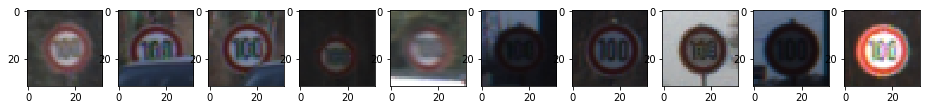

Class: 8. Name: "Speed limit (120km/h)". Samples: 1260.


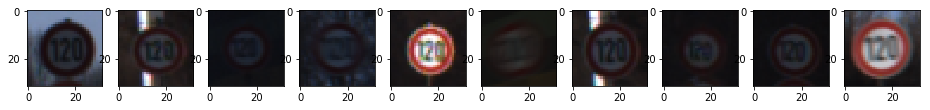

Class: 9. Name: "No passing". Samples: 1320.


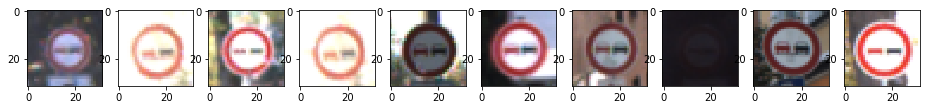

Class: 10. Name: "No passing for vehicles over 3.5 metric tons". Samples: 1800.


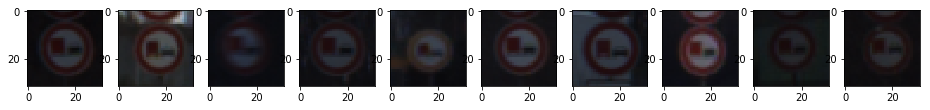

Class: 11. Name: "Right-of-way at the next intersection". Samples: 1170.


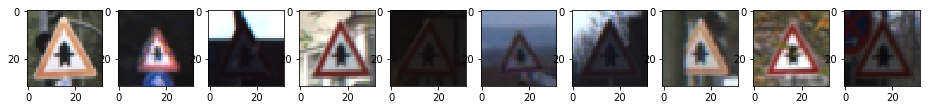

Class: 12. Name: "Priority road". Samples: 1890.


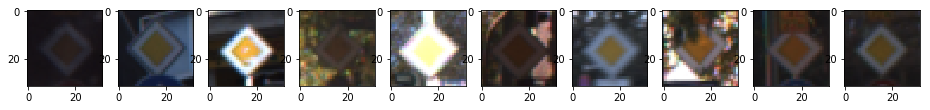

Class: 13. Name: "Yield". Samples: 1920.


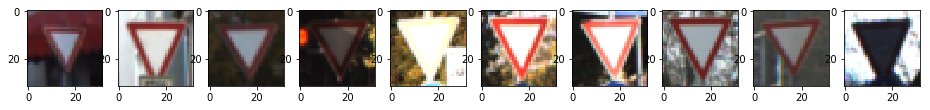

Class: 14. Name: "Stop". Samples: 690.


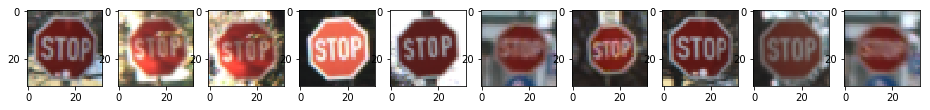

Class: 15. Name: "No vehicles". Samples: 540.


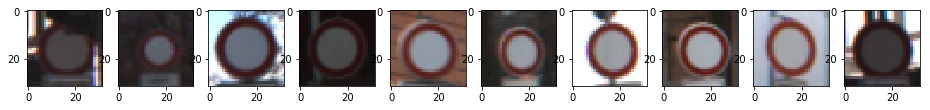

Class: 16. Name: "Vehicles over 3.5 metric tons prohibited". Samples: 360.


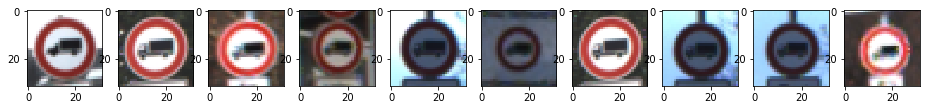

Class: 17. Name: "No entry". Samples: 990.


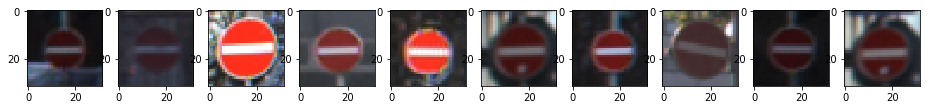

Class: 18. Name: "General caution". Samples: 1080.


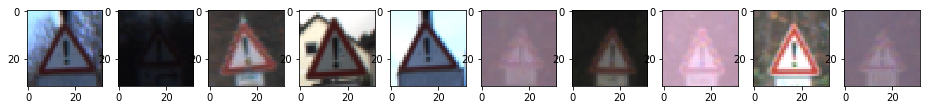

Class: 19. Name: "Dangerous curve to the left". Samples: 180.


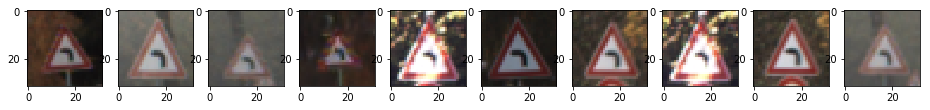

Class: 20. Name: "Dangerous curve to the right". Samples: 300.


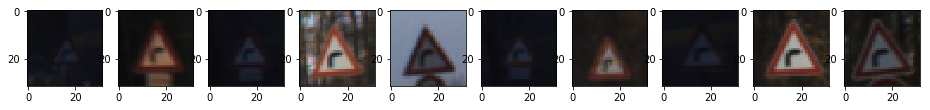

Class: 21. Name: "Double curve". Samples: 270.


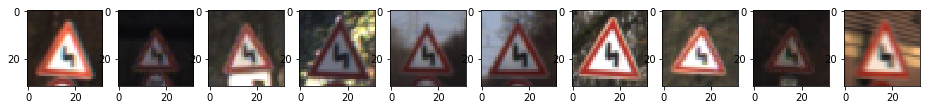

Class: 22. Name: "Bumpy road". Samples: 330.


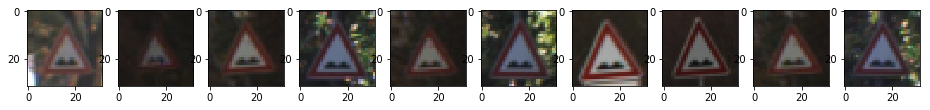

Class: 23. Name: "Slippery road". Samples: 450.


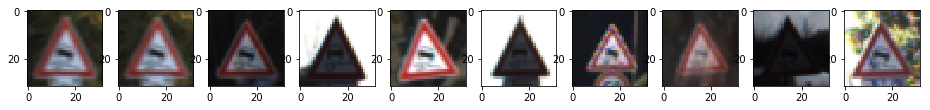

Class: 24. Name: "Road narrows on the right". Samples: 240.


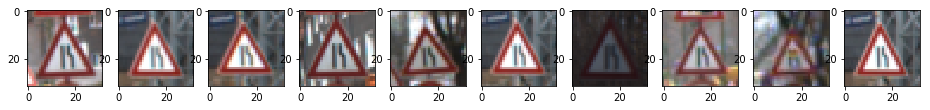

Class: 25. Name: "Road work". Samples: 1350.


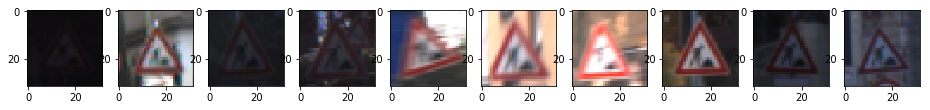

Class: 26. Name: "Traffic signals". Samples: 540.


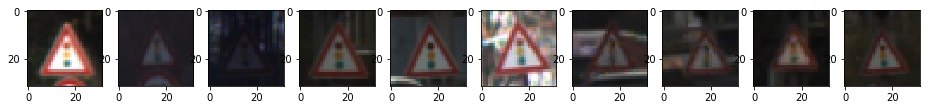

Class: 27. Name: "Pedestrians". Samples: 210.


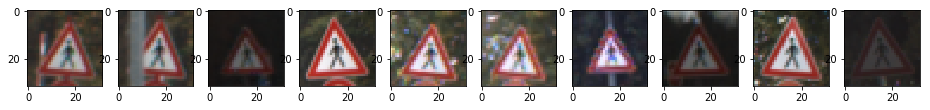

Class: 28. Name: "Children crossing". Samples: 480.


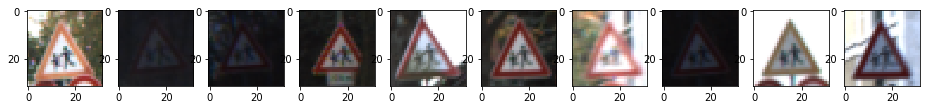

Class: 29. Name: "Bicycles crossing". Samples: 240.


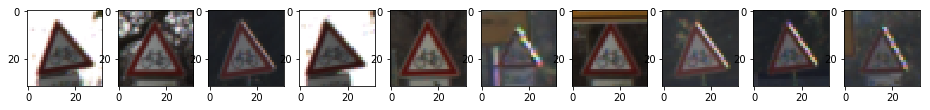

Class: 30. Name: "Beware of ice/snow". Samples: 390.


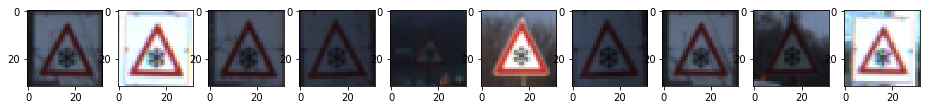

Class: 31. Name: "Wild animals crossing". Samples: 690.


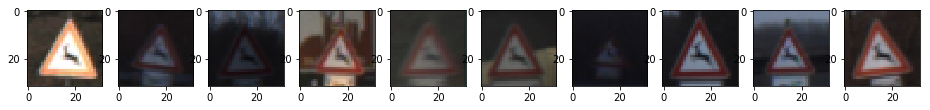

Class: 32. Name: "End of all speed and passing limits". Samples: 210.


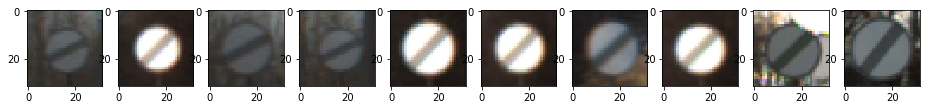

Class: 33. Name: "Turn right ahead". Samples: 599.


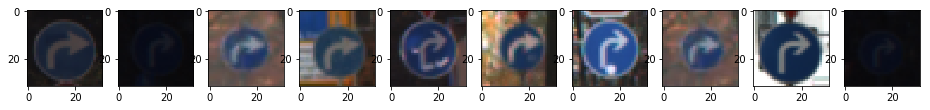

Class: 34. Name: "Turn left ahead". Samples: 360.


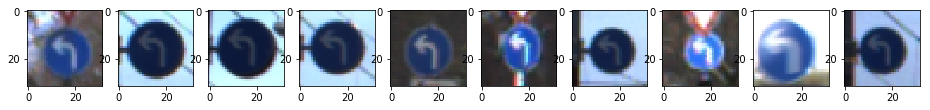

Class: 35. Name: "Ahead only". Samples: 1080.


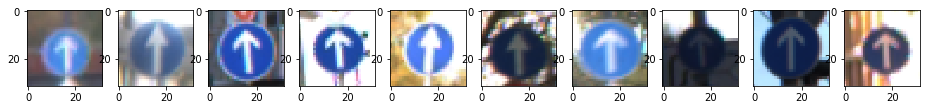

Class: 36. Name: "Go straight or right". Samples: 330.


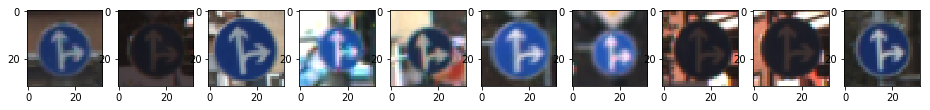

Class: 37. Name: "Go straight or left". Samples: 180.


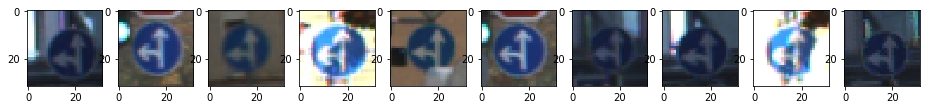

Class: 38. Name: "Keep right". Samples: 1860.


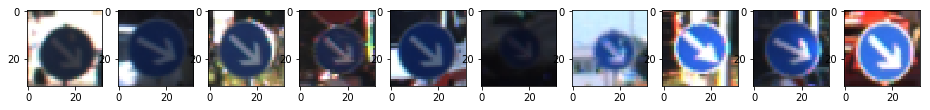

Class: 39. Name: "Keep left". Samples: 270.


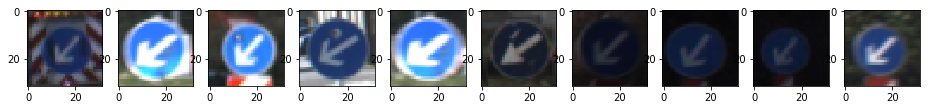

Class: 40. Name: "Roundabout mandatory". Samples: 300.


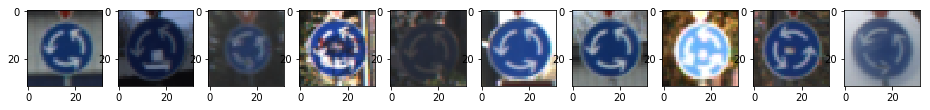

Class: 41. Name: "End of no passing". Samples: 210.


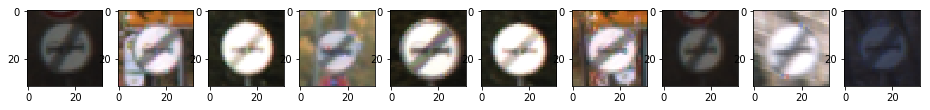

Class: 42. Name: "End of no passing by vehicles over 3.5 metric tons". Samples: 210.


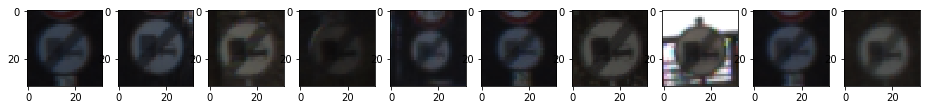

Samples distribution


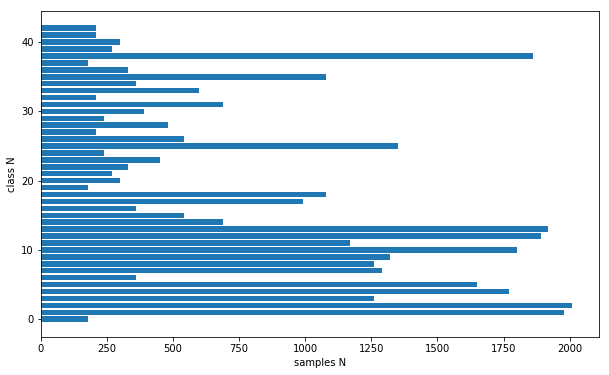

In [4]:
for n in range(n_classes):
    print('Class: {}. Name: "{}". Samples: {}.'.format(n, names[n], classes_c[n]))
    fg = plt.figure(figsize=[16,10])
    indexes = random.sample(range(classes_i[n], classes_i[n]+classes_c[n]), 10)
    for i in range(10):
        sp = fg.add_subplot(1, 10, i+1)
        sp.imshow(X_train_pre[indexes[i]])
    plt.show()

print('Samples distribution')
plt.figure(figsize=[10,6])
plt.barh(classes, classes_c)
plt.xlabel('samples N')
plt.ylabel('class N')
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (normalization and data augmentation)

Rotation example:


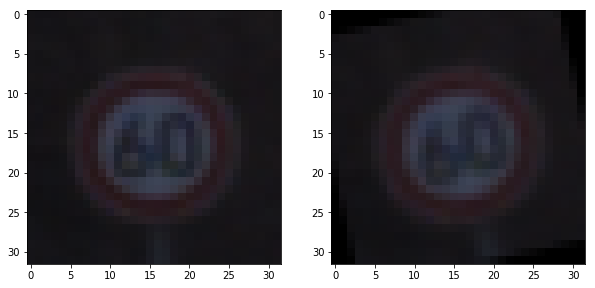

Perspective example:


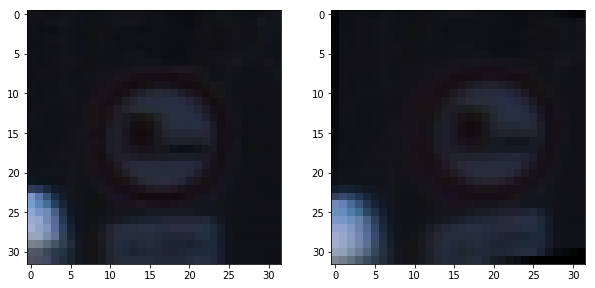

In [5]:
def normalize(X):
    X = (X - 128.)/128.
    return X

def rotate(x, a):
    rows, cols, _ = x.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),a,1)
    dst = cv2.warpAffine(x,M,(cols,rows))
    return dst
    #return skimage.transform.rotate(x, a, mode='edge', preserve_range=True)

def perspective(x, d):
    rows, cols, _ = x.shape
    pts1 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])
    pts2 = np.float32([[random.uniform(-d, d),random.uniform(-d, d)],
                       [rows+random.uniform(-d, d),random.uniform(-d, d)],
                       [random.uniform(-d, d),cols+random.uniform(-d, d)],
                       [rows+random.uniform(-d, d),cols+random.uniform(-d, d)]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(x,M,(32,32))
    return dst


def augment0(X, y):
    return X, y

def augment(X, y):
    augmentedX = []
    augmentedy = []
    for i in range(len(X)):
        for k in range(2):
            a = (random.random()-0.5)*40
            d = 3
#            augmentedX.append(rotate(X[i], a))
            augmentedX.append(perspective(rotate(X[i], a), d))
            augmentedy.append(y[i])
    return np.append(X, augmentedX, axis=0), np.append(y, augmentedy)

def augment2(X, y):
    augmentedX = []
    augmentedy = []
    samples_max = int(np.max(classes_c)*1.1)
    #print(samples_max)
    for n in range(n_classes):
        #print('Class: {}. Name: "{}". Samples: {}.'.format(n, names[n], classes_c[n]))
        indexes = [random.randint(classes_i[n], classes_i[n]+classes_c[n]-1)
                   for _ in range(samples_max-classes_c[n])]
        for i in indexes:
            a = (random.random()-0.5)*40
            augmentedX.append(rotate(X[i], a))
            augmentedy.append(y[i])
    return np.append(X, augmentedX, axis=0), np.append(y, augmentedy)

### Preprocess the data.
X_train_pre2, y_train = augment(X_train_pre, y_train_pre)
X_train = normalize(X_train_pre2)
X_valid = normalize(X_valid_pre)
X_test = normalize(X_test_pre)

print('Rotation example:')
i = random.randint(0,n_train)
fg = plt.figure(figsize=[10,10])
sp = fg.add_subplot(1, 2, 1)
sp.imshow(X_train_pre[i])
sp = fg.add_subplot(1, 2, 2)
sp.imshow(rotate(X_train_pre[i], (random.random()-0.5)*40))
plt.show()

print('Perspective example:')
i = random.randint(0,n_train)
fg = plt.figure(figsize=[10,10])
sp = fg.add_subplot(1, 2, 1)
sp.imshow(X_train_pre[i])
sp = fg.add_subplot(1, 2, 2)
sp.imshow(perspective(X_train_pre[i], 3))
plt.show()


### Layer functions

In [6]:
mu = 0
sigma = 0.1

def convLayer(input, kernell_size, depth, stride):
#    w = tf.get_variable('weights', shape=[kernell_size, kernell_size, int(input.shape[3]), depth],
#                       initializer = tf.contrib.layers.xavier_initializer())
#    b = tf.get_variable('biases', shape = [depth], initializer = tf.constant_initializer(0.0) )
    w = tf.Variable(tf.truncated_normal([kernell_size, kernell_size, int(input.shape[3]), depth], mean = mu, stddev = sigma, name='cw'))
    b = tf.Variable([0.] * depth, name='cb')
    strides = [1, stride, stride, 1]
    padding = 'SAME'
    return tf.nn.conv2d(input, w, strides, padding) + b

def activationLayer(input, activation_function):
    return activation_function(input)

def poolingLayer(input, k):
    return tf.nn.max_pool(input, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def fullyConectedLayer(input, output_size):
#    w = tf.get_variable('weights', shape=[int(input.shape[1]), output_size],
#                        initializer = tf.contrib.layers.xavier_initializer() )
#    b =tf.get_variable('biases', shape = [output_size], initializer = tf.constant_initializer(0.0) )
    w = tf.Variable(tf.truncated_normal([int(input.shape[1]), output_size], mean = mu, stddev = sigma), name='fw')
    b = tf.Variable([0.] * output_size, name='fb')
    return tf.add(tf.matmul(input, w), b)

def dropout(input, keep_prob):
    return tf.nn.dropout(input, keep_prob)


### Net Architecture

In [7]:
def Net(input, keep_prob, out_shape):    
    
    with tf.variable_scope('conv1', reuse=tf.AUTO_REUSE):
        conv1 = convLayer(input, 5, 32, 1)
        act1 = activationLayer(conv1, tf.nn.relu)
        dp1 = dropout(act1, keep_prob[0])
        pool1 = poolingLayer(dp1, 2)

    with tf.variable_scope('conv2', reuse=tf.AUTO_REUSE):
        conv2 = convLayer(pool1, 5, 64, 1)
        act2 = activationLayer(conv2, tf.nn.relu)
        dp2 = dropout(act2, keep_prob[1])
        pool2 = poolingLayer(dp2, 2)
        
    with tf.variable_scope('conv3', reuse=tf.AUTO_REUSE):
        conv3 = convLayer(pool2, 5, 64, 1)
        act3 = activationLayer(conv3, tf.nn.relu)
        dp3 = dropout(act3, keep_prob[2])
        pool3 = poolingLayer(dp3, 2)
    
    with tf.variable_scope('fc1', reuse=tf.AUTO_REUSE):
        #pf1 = tf.contrib.layers.flatten(pool1)
        #pf2 = tf.contrib.layers.flatten(pool2)
        #pf3 = tf.contrib.layers.flatten(pool3)
        #fl1 = tf.concat([pf1, pf2, pf3], 1)
        fl1 = tf.contrib.layers.flatten(pool3)
        fc1 = fullyConectedLayer(fl1, 256)
        act4 = activationLayer(fc1, tf.nn.relu)
        dp4 = dropout(act4, keep_prob[3])

    with tf.variable_scope('fc2', reuse=tf.AUTO_REUSE):
        fc2 = fullyConectedLayer(dp4, 128)
        act5 = activationLayer(fc2, tf.nn.relu)
        dp5 = dropout(act5, keep_prob[4])

    with tf.variable_scope('logits', reuse=tf.AUTO_REUSE):
        logits = fullyConectedLayer(dp5, out_shape)

    return logits

### Set parameters

In [8]:
rate = 0.001
EPOCHS = 30
BATCH_SIZE = 128
useTensorBoard = False
logs_path = '/tmp/tensorflow_logs/example/'
save_path = './best'
keep_prob_train = [0.9, 0.9, 0.9, 0.5, 0.5]
keep_prob_valid = [1.]*len(keep_prob_train)

### Preparations

In [9]:
x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]), name='X')
#x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], X_train.shape[3]))
y = tf.placeholder(tf.int32, (None), name='y')
keep_prob = tf.placeholder(tf.float32, (5), name='kp')
one_hot_y = tf.one_hot(y, n_classes)

# set the net
logits = Net(x, keep_prob, n_classes)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()
best_acuracy = 0

if useTensorBoard:
    tf.summary.scalar("loss", loss_operation)
    tf.summary.scalar("accuracy", accuracy_operation)
    for var in tf.trainable_variables():
        tf.summary.histogram(var.name, var)
    merged = tf.summary.merge_all()

def Validate(Xv, yv):
    num_valid_examples = len(Xv)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_valid_examples, BATCH_SIZE):
        batch_x, batch_y = Xv[offset:offset+BATCH_SIZE], yv[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_valid})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_valid_examples


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



### Train and Validate the Model

In [10]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_train_examples = len(X_train)

    if useTensorBoard:
        summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    print("Training started.")
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        avg_cost = 0
        total_batches = 0
        for offset in range(0, num_train_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
            if useTensorBoard:
                _, c, summary = sess.run([training_operation, loss_operation, merged],
                                         feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_train})
                summary_writer.add_summary(summary)
            else:
                _, c = sess.run([training_operation, loss_operation],
                                feed_dict={x: batch_x, y: batch_y, keep_prob: keep_prob_train})
            total_batches += 1
            avg_cost += c
        avg_cost = avg_cost / total_batches
            
        # Calculate validation accuracy
        validation_accuracy = Validate(X_valid, y_valid)
        if validation_accuracy > best_acuracy:
            best_acuracy = validation_accuracy
            saver.save(sess, save_path)
        print("EPOCH: {}. Average cost: {:.6f}. Validation Accuracy = {:.3f}".format(i, avg_cost, validation_accuracy))
        
    print("Finished.")
    
with tf.Session() as sess:
    saver.restore(sess, save_path)
    accuracy = Validate(X_valid, y_valid)
    print("Final validation accuracy = {:.3f}".format(accuracy))

Training started.
EPOCH: 0. Average cost: 2.295369. Validation Accuracy = 0.582
EPOCH: 1. Average cost: 0.952652. Validation Accuracy = 0.842
EPOCH: 2. Average cost: 0.498705. Validation Accuracy = 0.937
EPOCH: 3. Average cost: 0.320373. Validation Accuracy = 0.948
EPOCH: 4. Average cost: 0.236119. Validation Accuracy = 0.964
EPOCH: 5. Average cost: 0.181750. Validation Accuracy = 0.959
EPOCH: 6. Average cost: 0.156638. Validation Accuracy = 0.954
EPOCH: 7. Average cost: 0.135305. Validation Accuracy = 0.964
EPOCH: 8. Average cost: 0.114829. Validation Accuracy = 0.970
EPOCH: 9. Average cost: 0.110829. Validation Accuracy = 0.968
EPOCH: 10. Average cost: 0.102613. Validation Accuracy = 0.965
EPOCH: 11. Average cost: 0.095939. Validation Accuracy = 0.965
EPOCH: 12. Average cost: 0.086470. Validation Accuracy = 0.965
EPOCH: 13. Average cost: 0.078610. Validation Accuracy = 0.972
EPOCH: 14. Average cost: 0.080237. Validation Accuracy = 0.961
EPOCH: 15. Average cost: 0.078526. Validation A

### Test the model

In [15]:
with tf.Session() as sess:
    saver.restore(sess, save_path)
    accuracy = Validate(X_train, y_train)
    print("Train accuracy = {:.3f}".format(accuracy))
    accuracy = Validate(X_valid, y_valid)
    print("Validation accuracy = {:.3f}".format(accuracy))
    accuracy = Validate(X_test, y_test)
    print("Test accuracy = {:.3f}".format(accuracy))

INFO:tensorflow:Restoring parameters from ./best
Train accuracy = 0.997
Validation accuracy = 0.978
Test accuracy = 0.967


---

## Step 3: Test a Model on New Images


### Load and Output the Images

New images:


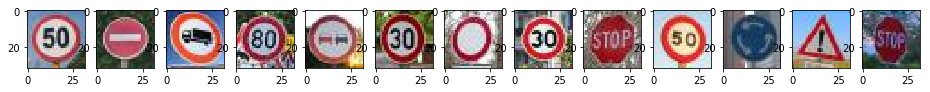

Classes n:  [2, 17, 16, 5, 9, 1, 15, 1, 14, 2, 40, 18, 14]


In [12]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
newImagesFolder = './newSigns'
images = []
images_c = []
for filename in os.listdir(newImagesFolder):
    if filename.endswith('jpg'):
        im = cv2.imread(os.path.join(newImagesFolder, filename))
        b,g,r = cv2.split(im)       # get b,g,r
        im = cv2.merge([r,g,b])     # switch it to rgb
        images.append(im)
        c = filename.split('_')[0]
        images_c.append(int(c))
print('New images:')
fg = plt.figure(figsize=[16,10])
for i in range(len(images)):
    sp = fg.add_subplot(1, len(images), i+1)
    sp.imshow(images[i])
plt.show()
print('Classes n: ', images_c)

### Predict the Sign Type for Each Image

In [13]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
pred_c = []
X_new = normalize(np.array(images))
with tf.Session() as sess:
    saver.restore(sess, save_path)
    pred = sess.run(logits, feed_dict={x: X_new, keep_prob: keep_prob_valid})

pred_c = np.argmax(pred, axis=1)
print('New images predicted class numberers and descriptions:')
print('| Estimated class | Real class |')
print('|:---------------------:|:---------------------------------------------:|')
for c,r in zip(pred_c, images_c):
    print('| {} | {} |'.format(names[c], names[r]))

INFO:tensorflow:Restoring parameters from ./best
New images predicted class numberers and descriptions:
| Estimated class | Real class |
|:---------------------:|:---------------------------------------------:|
| Speed limit (50km/h) | Speed limit (50km/h) |
| No entry | No entry |
| Speed limit (20km/h) | Vehicles over 3.5 metric tons prohibited |
| Speed limit (80km/h) | Speed limit (80km/h) |
| No passing | No passing |
| Speed limit (30km/h) | Speed limit (30km/h) |
| No vehicles | No vehicles |
| Speed limit (30km/h) | Speed limit (30km/h) |
| Stop | Stop |
| Speed limit (80km/h) | Speed limit (50km/h) |
| Roundabout mandatory | Roundabout mandatory |
| General caution | General caution |
| Stop | Stop |


### Analyze Performance

In [16]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
s = (np.array(images_c) == np.array(pred_c)).sum()
acc_perc = s / len(pred_c) * 100
print('New images accuracy: {}/{} {:.0f}%'.format(s, len(pred_c), acc_perc))

New images accuracy: 11/13 85%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./best
Speed limit (50km/h)


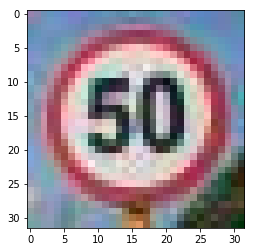

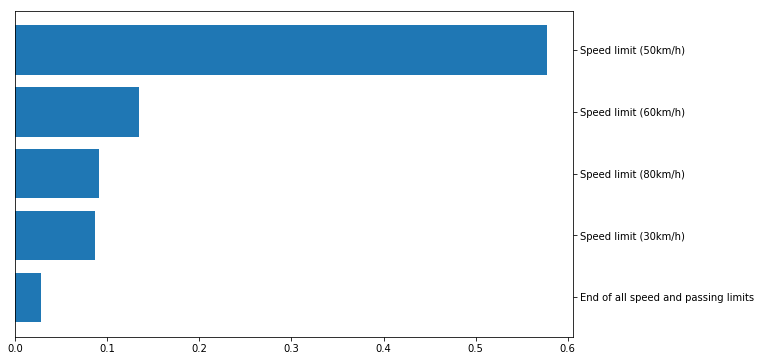

--------------------------------------------------------------------------------------

No entry


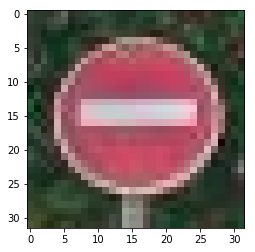

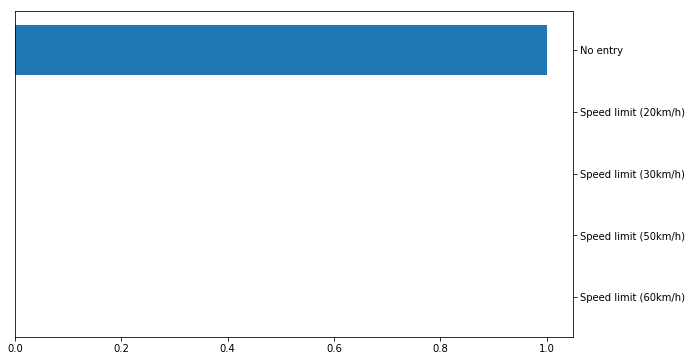

--------------------------------------------------------------------------------------

Vehicles over 3.5 metric tons prohibited


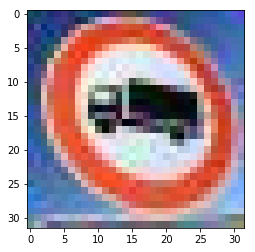

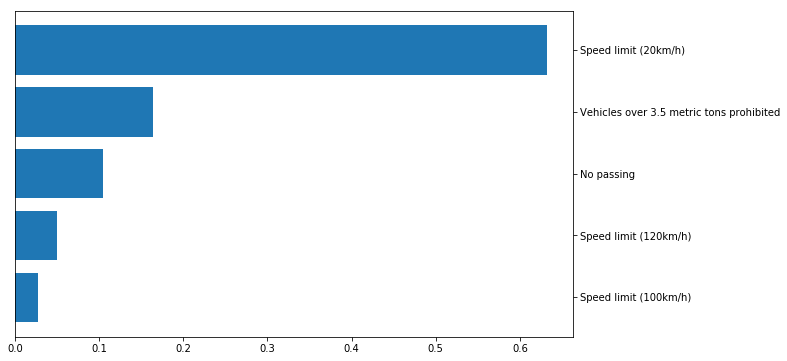

--------------------------------------------------------------------------------------

Speed limit (80km/h)


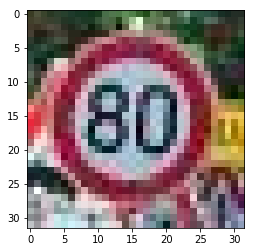

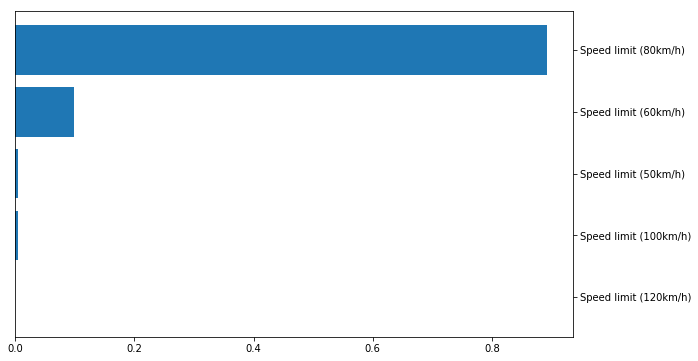

--------------------------------------------------------------------------------------

No passing


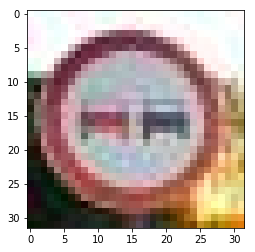

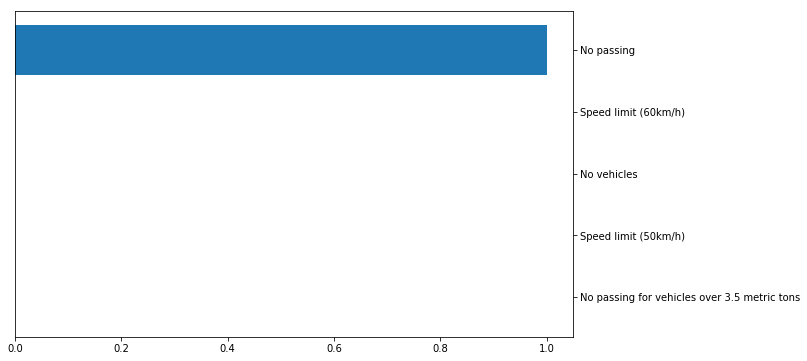

--------------------------------------------------------------------------------------

Speed limit (30km/h)


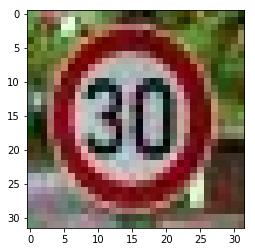

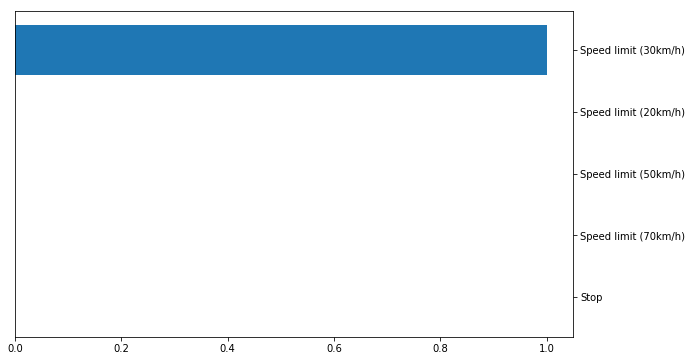

--------------------------------------------------------------------------------------

No vehicles


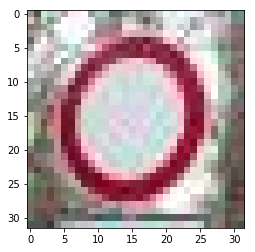

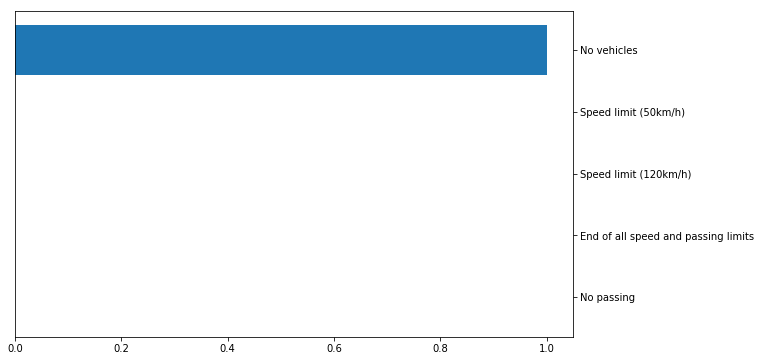

--------------------------------------------------------------------------------------

Speed limit (30km/h)


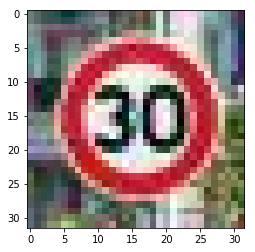

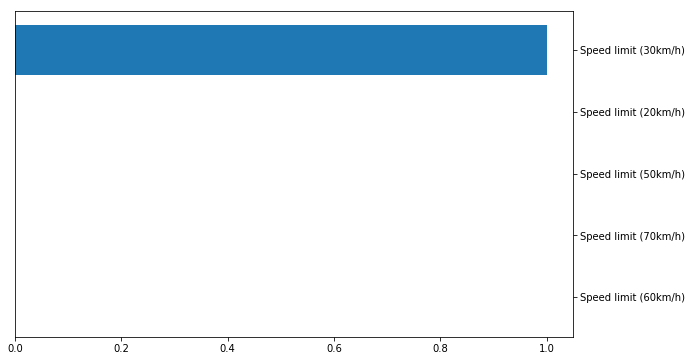

--------------------------------------------------------------------------------------

Stop


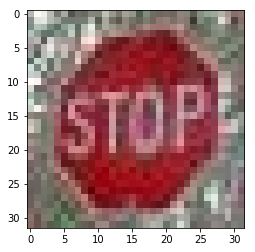

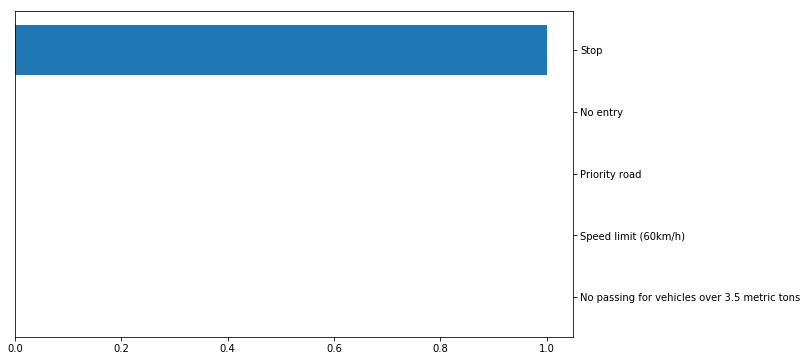

--------------------------------------------------------------------------------------

Speed limit (50km/h)


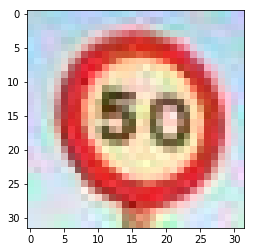

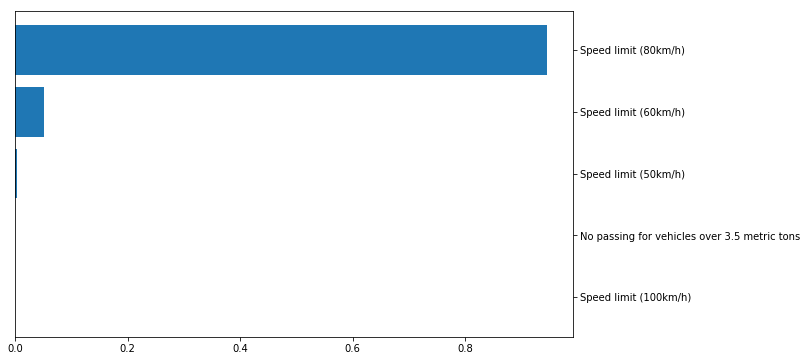

--------------------------------------------------------------------------------------

Roundabout mandatory


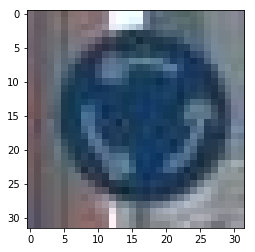

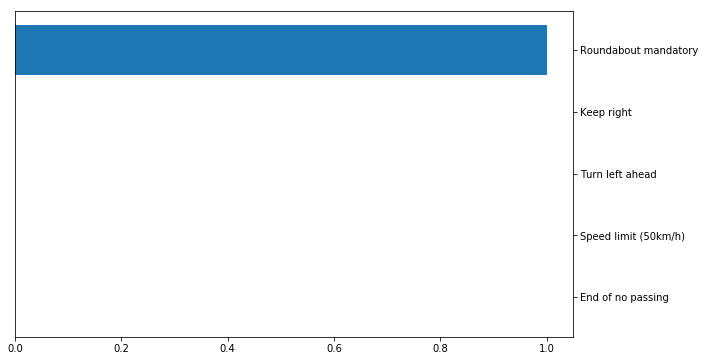

--------------------------------------------------------------------------------------

General caution


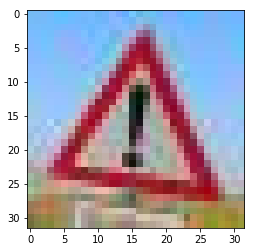

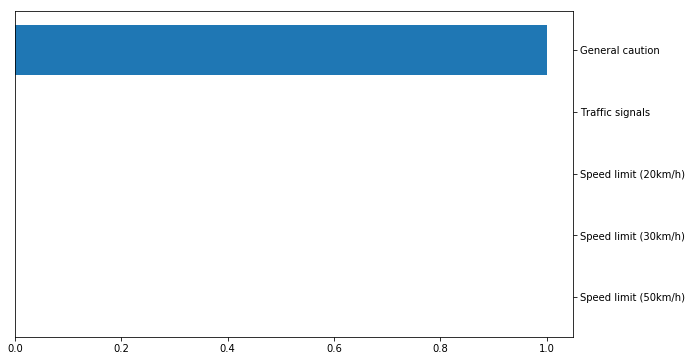

--------------------------------------------------------------------------------------

Stop


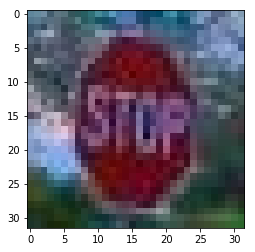

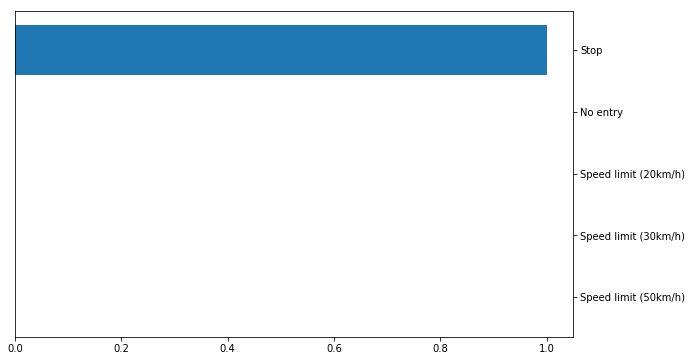

--------------------------------------------------------------------------------------



In [17]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
with tf.Session() as sess:
    saver.restore(sess, save_path)
    val, ind = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x: X_new, keep_prob: keep_prob_valid})
    
ind_all = range(5,0,-1)

for i in range(len(images)):
    print(names[images_c[i]])
    plt.imshow(images[i])
    
    f = plt.figure(figsize=[10,6])
    a = f.add_subplot(111)
    a.yaxis.tick_right()
    plt.barh(ind_all, val[i])
    plt.yticks(ind_all, [names[j] for j in ind[i]])

    plt.show()
    print("--------------------------------------------------------------------------------------\n")


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

In [18]:
### Visualize your network's feature maps here.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = np.array(normalize(image_input), dtype='float32')
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x: image_input, keep_prob: keep_prob_valid})
    #print(activation.shape)
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,150))
    for featuremap in range(featuremaps):
        plt.subplot(60,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

INFO:tensorflow:Restoring parameters from ./best


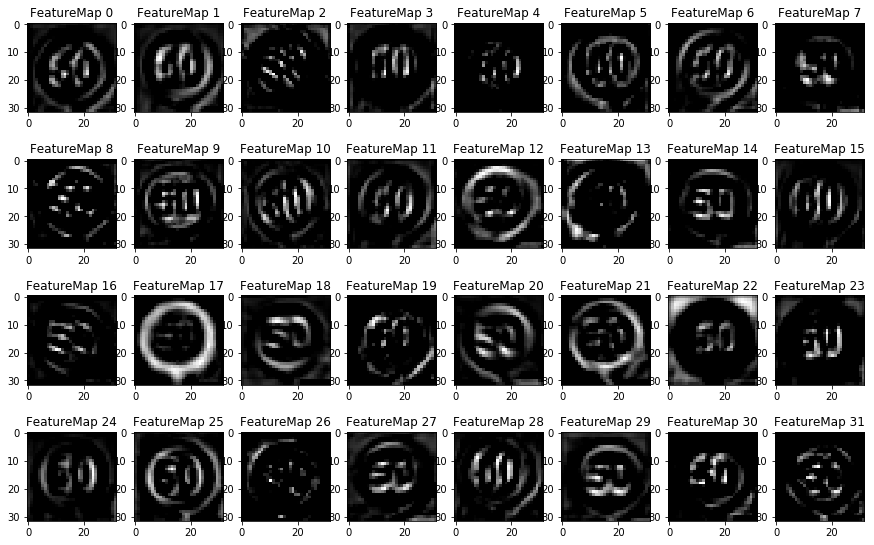

In [19]:
t = tf.get_default_graph().get_tensor_by_name('conv1/Relu:0')
inp = np.array([images[0]])
with tf.Session() as sess:
    saver.restore(sess, save_path)
    outputFeatureMap(inp, t)